# Weather Model Training v4.0 - Date-Based Seasonality Model
    
Implementasi **Date-Based Seasonality Model** sesuai `training_guide_v4.md`.
    
## Karakteristik v4.0:
*   **Input:** HANYA komponen waktu (`day`, `month`, `year`, `hour`).
*   **Tanpa Sensor Input:** Tidak membutuhkan data suhu/kelembaban masa lalu untuk prediksi.
*   **Strategi:** Direct Mapping (Tanggal -> Cuaca), cocok untuk forecasting jangka panjang.


## 1. Persiapan Lingkungan

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR

try:
    from xgboost import XGBRegressor, XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

import joblib
print(f"Libraries loaded | XGBoost: {XGBOOST_AVAILABLE}")

Libraries loaded | XGBoost: True


## 2. Load Data

In [3]:
DATA_PATH = '../data/historical_data_2000_2024_v2.csv'
df = pd.read_csv(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
print(f"Dataset: {len(df):,} rows x {len(df.columns)} cols")
print(f"Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
df.head()

Dataset: 227,352 rows x 39 cols
Range: 2000-01-01 00:00:00 to 2025-12-07 23:00:00


id           timestamp  hour  day  month  year  temp  humidity  windspeed  \
0   0 2000-01-01 00:00:00     0    1      1  2000  21.8        98        4.0   
1   1 2000-01-01 01:00:00     1    1      1  2000  21.4        99        4.0   
2   2 2000-01-01 02:00:00     2    1      1  2000  21.4        98        3.2   
3   3 2000-01-01 03:00:00     3    1      1  2000  21.2        99        4.6   
4   4 2000-01-01 04:00:00     4    1      1  2000  21.0        99        3.6   

   sealevelpressure  ...  surface_pressure_mean_daily  \
0            1008.4  ...                        983.6   
1            1007.9  ...                        983.6   
2            1007.4  ...                        983.6   
3            1007.0  ...                        983.6   
4            1006.9  ...                        983.6   

   surface_pressure_max_daily  surface_pressure_min_daily  \
0                       985.4                       981.3   
1                       985.4                       981.3   
2                       985.4                       981.3   
3                       985.4                       981.3   
4                       985.4                       981.3   

   windspeed_mean_daily  windspeed_max_daily  windspeed_min_daily  \
0                   6.3                 12.1                  1.4   
1                   6.3                 12.1                  1.4   
2                   6.3                 12.1                  1.4   
3                   6.3                 12.1                  1.4   
4                   6.3                 12.1                  1.4   

   wind_gusts_mean_daily wind_gusts_max_daily  wind_gusts_min_daily  \
0                   17.3                 30.2                   6.8   
1                   17.3                 30.2                   6.8   
2                   17.3                 30.2                   6.8   
3                   17.3                 30.2                   6.8   
4                   17.3                 30.2                   6.8   

   wind_direction_dominant_daily  
0                            300  
1                            300  
2                            300  
3                            300  
4                            300  

[5 rows x 39 columns]

## 3. EDA (Exploratory Data Analysis)

### 3.1 Statistik Deskriptif

In [4]:
df.describe()

id            timestamp           hour            day  \
count  227352.000000               227352  227352.000000  227352.000000   
mean   113675.500000  2012-12-19 11:30:00      11.500000      15.720785   
min         0.000000  2000-01-01 00:00:00       0.000000       1.000000   
25%     56837.750000  2006-06-26 05:45:00       5.750000       8.000000   
50%    113675.500000  2012-12-19 11:30:00      11.500000      16.000000   
75%    170513.250000  2019-06-14 17:15:00      17.250000      23.000000   
max    227351.000000  2025-12-07 23:00:00      23.000000      31.000000   
std     65631.013538                  NaN       6.922202       8.802606   

               month           year           temp       humidity  \
count  227352.000000  227352.000000  227352.000000  227352.000000   
mean        6.508815    2012.467962      25.537443      79.352783   
min         1.000000    2000.000000      17.000000      16.000000   
25%         4.000000    2006.000000      23.200000      71.000000   
50%         7.000000    2012.000000      25.000000      83.000000   
75%         9.000000    2019.000000      27.500000      93.000000   
max        12.000000    2025.000000      37.800000     100.000000   
std         3.442091       7.483434       3.021603      16.927844   

           windspeed  sealevelpressure  ...  surface_pressure_mean_daily  \
count  227352.000000     227352.000000  ...                227352.000000   
mean        6.158368       1010.092556  ...                   986.395915   
min         0.000000       1002.200000  ...                   980.900000   
25%         3.400000       1008.800000  ...                   985.500000   
50%         5.200000       1010.200000  ...                   986.500000   
75%         8.000000       1011.400000  ...                   987.300000   
max        34.700000       1016.800000  ...                   990.900000   
std         3.900730          1.867010  ...                     1.368260   

       surface_pressure_max_daily  surface_pressure_min_daily  \
count               227352.000000               227352.000000   
mean                   988.209374                  984.307769   
min                    982.100000                  978.700000   
25%                    987.200000                  983.500000   
50%                    988.300000                  984.400000   
75%                    989.200000                  985.200000   
max                    993.000000                  989.400000   
std                      1.470413                    1.333063   

       windspeed_mean_daily  windspeed_max_daily  windspeed_min_daily  \
count         227352.000000        227352.000000        227352.000000   
mean               6.160234            11.301858             1.955927   
min                1.700000             3.700000             0.000000   
25%                4.300000             8.400000             0.800000   
50%                5.500000            10.400000             1.500000   
75%                7.200000            13.300000             2.400000   
max               26.900000            34.700000            22.900000   
std                2.656991             4.188278             1.935608   

       wind_gusts_mean_daily  wind_gusts_max_daily  wind_gusts_min_daily  \
count          227352.000000         227352.000000         227352.000000   
mean               16.849784             29.356223              6.813438   
min                 8.500000             11.500000              0.700000   
25%                13.500000             24.100000              4.700000   
50%                15.700000             27.700000              5.800000   
75%                18.800000             32.800000              7.600000   
max                58.500000             73.800000             46.400000   
std                 4.961513              7.465348              3.879975   

       wind_direction_dominant_daily  
count                  227352.000000  
mean                      19

### 3.2 Distribusi Parameter Hourly

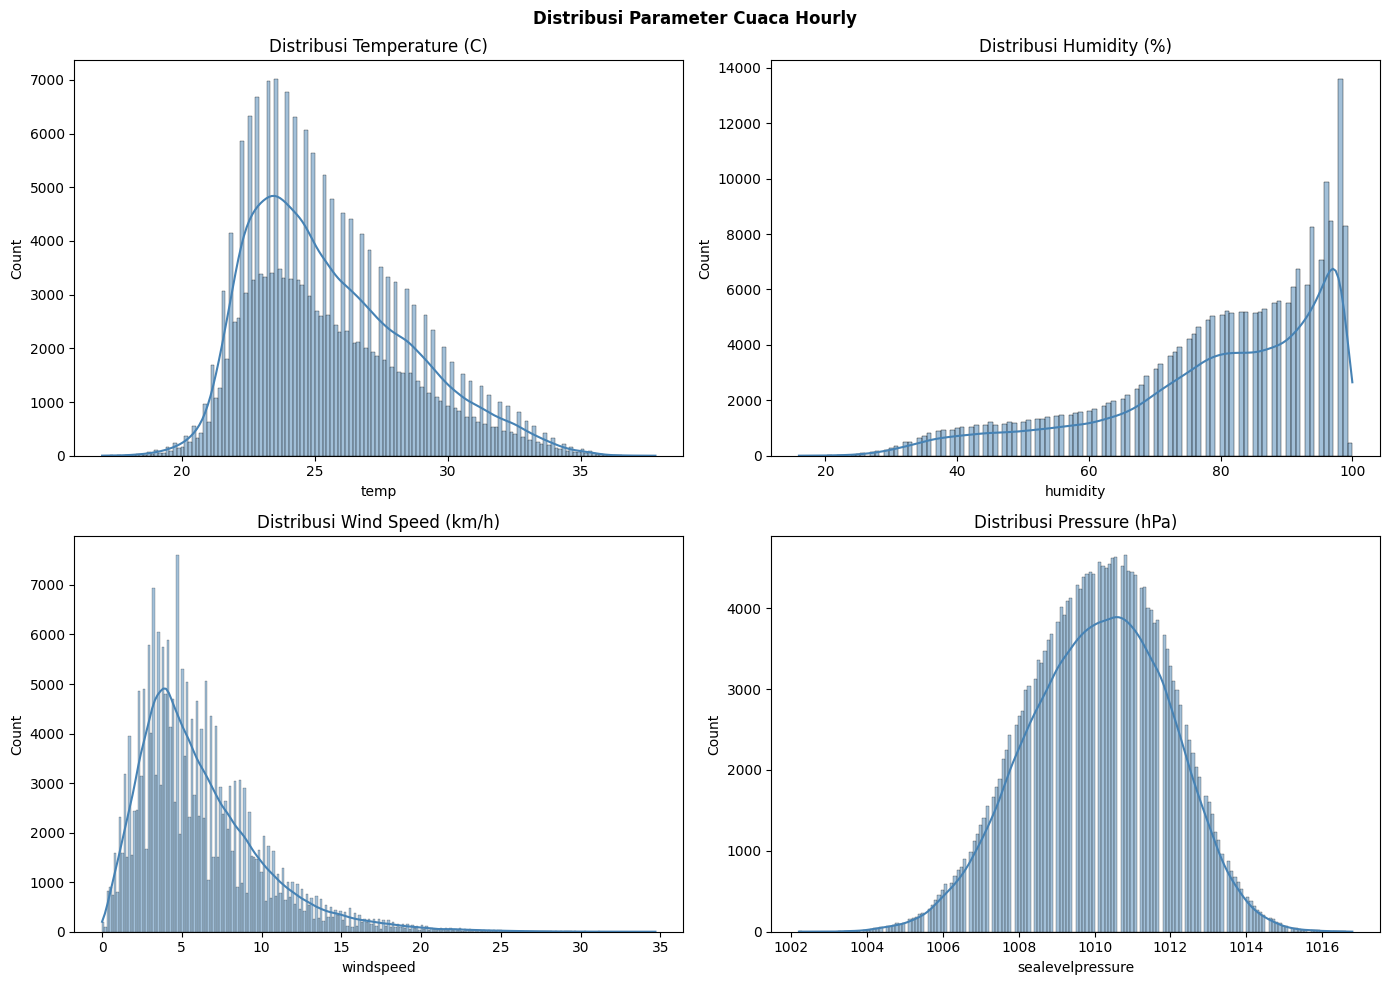

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
params = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
titles = ['Temperature (C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Pressure (hPa)']
for ax, param, title in zip(axes.flatten(), params, titles):
    sns.histplot(df[param], kde=True, ax=ax, color='steelblue')
    ax.set_title(f'Distribusi {title}')
plt.suptitle('Distribusi Parameter Cuaca Hourly', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.3 Korelasi Heatmap

In [6]:
# plt.figure(figsize=(12, 8))
# cols = ['temp', 'humidity', 'windspeed', 'sealevelpressure', 'rain', 'weather_code']
# sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm', center=0)
# plt.title('Correlation Matrix')
# plt.show()

### 3.4 Weather Code vs Rain

In [7]:
df.groupby('conditions')[['rain']].agg(['mean', 'count'])

rain       
                      mean  count
conditions                       
Clear             0.000000  23299
Overcast          0.000000  82028
Partially cloudy  0.000000  54989
Rain              0.374316  53325
Rain, Overcast    3.039487  13711

## 4. Feature Engineering

### 4.1 Label Encoding Hourly

In [8]:
df_hourly = df.copy()
le_conditions = LabelEncoder()
df_hourly['conditions_encoded'] = le_conditions.fit_transform(df_hourly['conditions'])
# If 'conditions_dominant' refers to the same 'conditions' column,
# use the already fitted encoder to transform, or assign the same encoded column.
# If 'conditions_dominant' is a different column, a separate encoder might be needed.
print("Label encoding done")
print("Label mapping for 'conditions':")
# Store the original labels for use in the confusion matrix
original_condition_labels = le_conditions.classes_
for i, label in enumerate(original_condition_labels):
    print(f"{label}: {i}")

Label encoding done
Label mapping for 'conditions':
Clear: 0
Overcast: 1
Partially cloudy: 2
Rain: 3
Rain, Overcast: 4


### 4.5 Preprocessing Data Daily

In [9]:
# # Agregasi hourly ke daily
# df_daily = df.groupby(['year', 'month', 'day']).agg({
#     'temp': ['min', 'max', 'mean'],
#     'humidity': 'mean',
#     'windspeed': 'mean',
#     'sealevelpressure': 'mean',
#     'conditions': lambda x: x.mode()[0],
#     'rain': 'sum'
# }).reset_index()

# df_daily.columns = ['year', 'month', 'day', 'temp_min', 'temp_max', 'temp_mean',
#                     'humidity_avg', 'windspeed_avg', 'pressure_avg',
#                     'conditions_dominant', 'rain_total']

# le_conditions_daily = LabelEncoder()
# df_daily['conditions_daily_encoded'] = le_conditions_daily.fit_transform(df_daily['conditions_dominant'])
# print(f"Daily: {len(df_daily):,} rows")

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df['timestamp'] = pd.to_datetime(df['timestamp'])

# 1) Ambil fitur harian numerik langsung dari kolom *_daily (tanpa hitung ulang)
daily_num_cols = [
    'temp_min_daily','temp_max_daily','temp_mean_daily',
    'humidity_mean_daily',
    'windspeed_mean_daily',
    'pressure_msl_mean_daily',
    'rain_sum_daily'
]

df_daily_num = (
    df.sort_values('timestamp')
      .groupby(['year','month','day'], as_index=False)[daily_num_cols]
      .first()
      .rename(columns={
          'temp_min_daily':'temp_min',
          'temp_max_daily':'temp_max',
          'temp_mean_daily':'temp_mean',
          'humidity_mean_daily':'humidity_avg',
          'windspeed_mean_daily':'windspeed_avg',
          'pressure_msl_mean_daily':'pressure_avg',
          'rain_sum_daily':'rain_total',
      })
)

# 2) "Rata-rata conditions per jam" => proporsi jam per kondisi dalam sehari
cond_dist = (
    df.dropna(subset=['conditions'])
      .groupby(['year','month','day'])['conditions']
      .value_counts(normalize=True)      # proporsi (0..1)
      .unstack(fill_value=0)
      .reset_index()
)

cond_cols = [c for c in cond_dist.columns if c not in ['year','month','day']]

# label harian = kondisi dengan proporsi terbesar
cond_dist['conditions_daily'] = cond_dist[cond_cols].idxmax(axis=1)
cond_dist['conditions_daily_conf'] = cond_dist[cond_cols].max(axis=1)  # seberapa dominan (mis. 0.75)

# (opsional) jadikan proporsi sebagai fitur model
cond_feat = cond_dist[['year','month','day'] + cond_cols].copy()
cond_feat = cond_feat.rename(columns={c: f'cond_pct_{c}' for c in cond_cols})

# 3) Gabungkan jadi df_daily final
df_daily = (
    df_daily_num
      .merge(cond_dist[['year','month','day','conditions_daily','conditions_daily_conf']],
             on=['year','month','day'], how='left')
      .merge(cond_feat, on=['year','month','day'], how='left')   # opsional, hapus kalau tidak perlu fitur proporsi
)

# Target klasifikasi kamu: conditions_daily
le_conditions_daily = LabelEncoder()
df_daily['conditions_daily_encoded'] = le_conditions_daily.fit_transform(df_daily['conditions_daily'].astype(str))

print(f"Daily: {len(df_daily):,} rows")
df_daily.head()


Daily: 9,473 rows


year  month  day  temp_min  temp_max  temp_mean  humidity_avg  \
0  2000      1    1      20.8      27.5       24.1            91   
1  2000      1    2      21.6      27.0       23.8            93   
2  2000      1    3      22.1      24.9       23.3            97   
3  2000      1    4      21.9      27.6       24.3            89   
4  2000      1    5      21.3      28.9       24.2            90   

   windspeed_avg  pressure_avg  rain_total conditions_daily  \
0            6.3        1007.3         4.4         Overcast   
1            7.5        1007.3         8.8             Rain   
2            5.2        1007.9        16.1             Rain   
3            3.6        1008.4         4.1             Rain   
4            3.8        1009.1        30.7         Overcast   

   conditions_daily_conf  cond_pct_Clear  cond_pct_Overcast  \
0               0.583333             0.0           0.583333   
1               0.666667             0.0           0.250000   
2               0.875000             0.0           0.000000   
3               0.583333             0.0           0.416667   
4               0.375000             0.0           0.375000   

   cond_pct_Partially cloudy  cond_pct_Rain  cond_pct_Rain, Overcast  \
0                        0.0       0.416667                 0.000000   
1                        0.0       0.666667                 0.083333   
2                        0.0       0.875000                 0.125000   
3                        0.0       0.583333                 0.000000   
4                        0.0       0.291667                 0.333333   

   conditions_daily_encoded  
0                         1  
1                         3  
2                         3  
3                         3  
4                         1

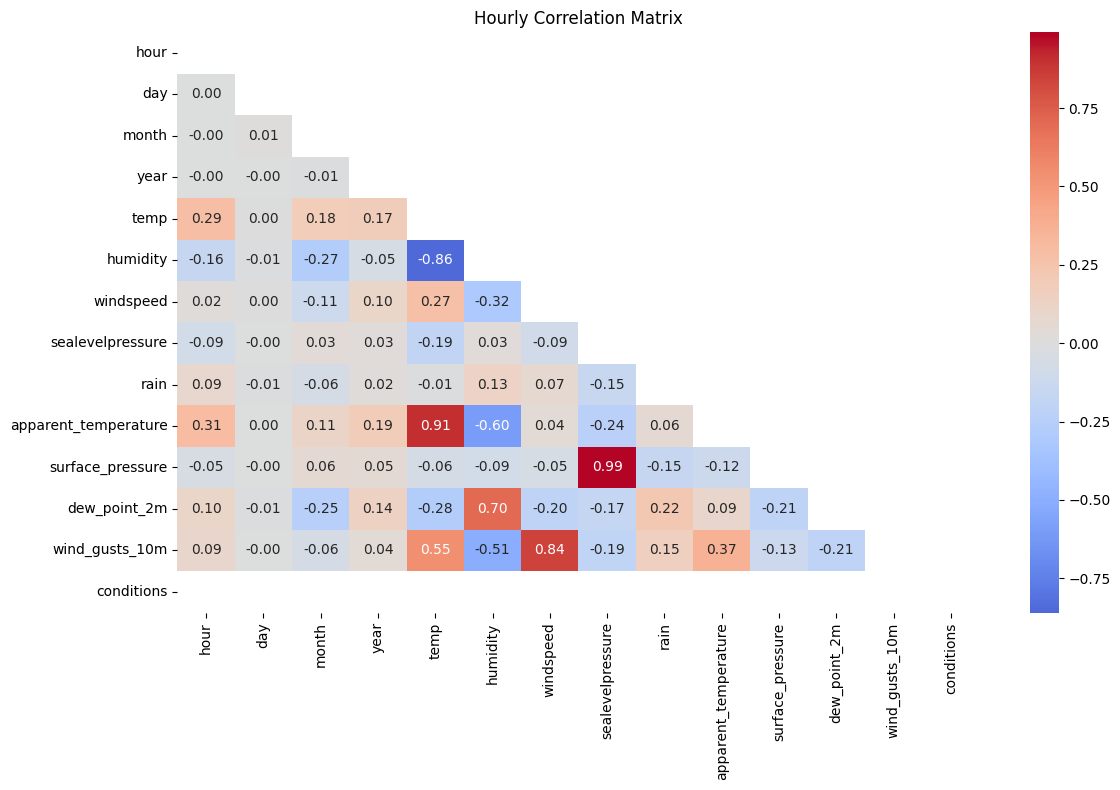

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

cols_hourly = [
    'hour', 'day', 'month', 'year',
    'temp', 'humidity', 'windspeed', 'sealevelpressure', 'rain',
    'apparent_temperature', 'surface_pressure', 'dew_point_2m',
    'wind_gusts_10m',
    'conditions',
    # opsional (circular): 'wind_direction_10m'
]

Xh = df[cols_hourly].apply(pd.to_numeric, errors='coerce')
corr_h = Xh.corr()

mask = np.triu(np.ones_like(corr_h, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_h, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Hourly Correlation Matrix')
plt.tight_layout()
plt.show()


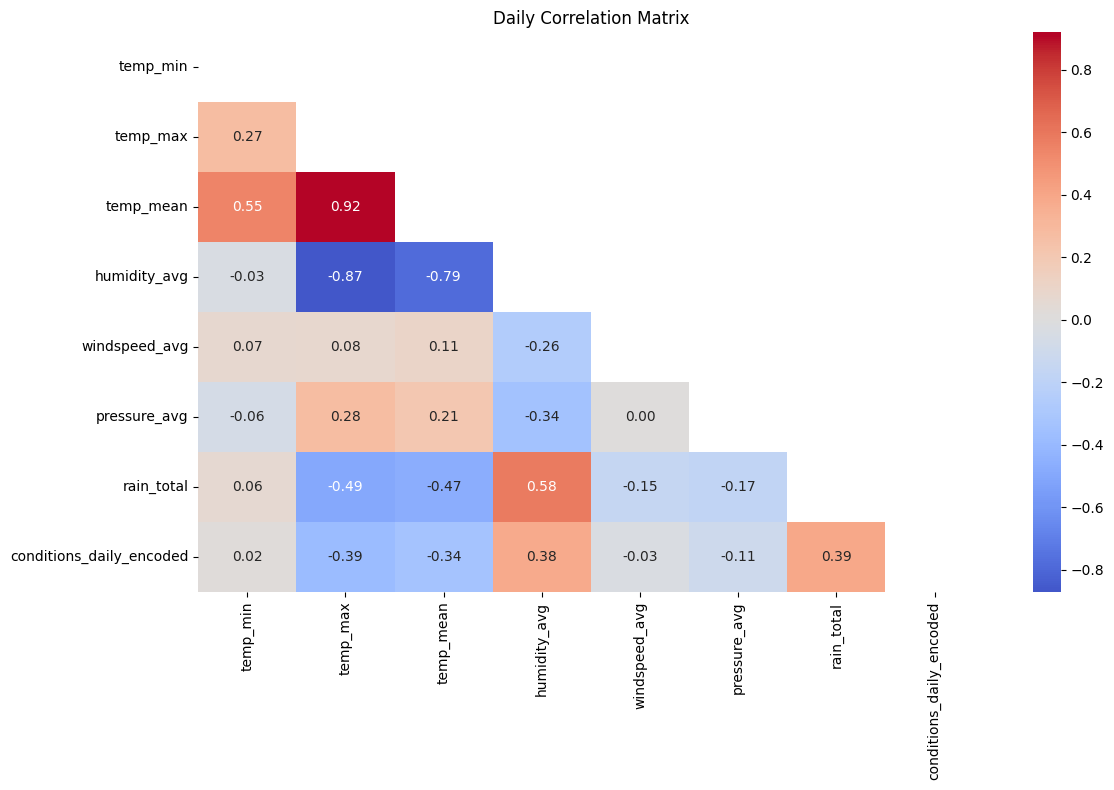

In [12]:
cols_daily = [
    # 'day', 'month', 'year',
    'temp_min', 'temp_max', 'temp_mean',
    'humidity_avg', 'windspeed_avg', 'pressure_avg',
    'rain_total',
    # pilih salah satu:
    'conditions_daily_encoded',   # rekomendasi (numerik)
    # atau kalau Anda pakai weather_code_daily langsung:
    # 'conditions_dominant',
    # opsional (circular): 'wind_direction_dominant'
]

Xd = df_daily[cols_daily].apply(pd.to_numeric, errors='coerce')
corr_d = Xd.corr()

mask = np.triu(np.ones_like(corr_d, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_d, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Daily Correlation Matrix')
plt.tight_layout()
plt.show()


## 5. Model Training

### 5.1 Define Features & Targets

In [13]:
hourly_feature_cols = ['day', 'month', 'year', 'hour']
daily_feature_cols = ['day', 'month', 'year']

# Target tetap sama
hourly_target_reg = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
hourly_target_clf = 'conditions_encoded'

daily_target_reg = ['temp_min', 'temp_max', 'temp_mean', 'humidity_avg', 'windspeed_avg', 'pressure_avg']
daily_target_clf = 'conditions_daily_encoded'


### 5.2 Data Split (HOURLY)

In [14]:
# Hourly Random Split
X_hourly_train, X_hourly_test, y_hourly_train_reg, y_hourly_test_reg = train_test_split(
    df_hourly[hourly_feature_cols], 
    df_hourly[hourly_target_reg], 
    test_size=0.2, 
    random_state=42
)
y_hourly_train_clf, y_hourly_test_clf = train_test_split(
    df_hourly[hourly_target_clf], test_size=0.2, random_state=42
)

print(f"Hourly Train: {len(X_hourly_train):,} | Test: {len(X_hourly_test):,}")

Hourly Train: 181,881 | Test: 45,471


### 5.3 Data Split (DAILY)

In [15]:
# Daily Random Split
X_daily_train, X_daily_test, y_daily_train_reg, y_daily_test_reg = train_test_split(
    df_daily[daily_feature_cols], 
    df_daily[daily_target_reg], 
    test_size=0.2, 
    random_state=42
)
y_daily_train_clf, y_daily_test_clf = train_test_split(
    df_daily[daily_target_clf], test_size=0.2, random_state=42
)

print(f"Daily Train: {len(X_daily_train):,} | Test: {len(X_daily_test):,}")

Daily Train: 7,578 | Test: 1,895


### 5.4 Define Model Regression & Classification

TUNING

In [16]:
SEED = 42

# # Baseline sesuai list kamu
# regression_models = {
#     "Linear Regression": LinearRegression(),
#     "K-Neighbors Regressor (Base)": KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
#     "Decision Tree Regressor (Base)": DecisionTreeRegressor(random_state=SEED, max_depth=10),
#     "Random Forest Regressor (Base, n=100)": RandomForestRegressor(
#         n_estimators=100, random_state=SEED, n_jobs=-1
#     ),
# }

# # Tuning candidates (dibandingkan satu per satu)
# REG_TUNING_CANDIDATES = {
#     "K-Neighbors Regressor": [
#         dict(n_neighbors=3,  weights="distance", p=2),
#         dict(n_neighbors=7,  weights="distance", p=2),
#         dict(n_neighbors=15, weights="uniform",  p=2),
#         dict(n_neighbors=25, weights="distance", p=1),  # Manhattan
#     ],
#     "Decision Tree Regressor": [
#         # fokus: max_depth + min_samples_leaf (+split) untuk bias-variance / overfitting
#         dict(max_depth=6,  min_samples_split=10, min_samples_leaf=3),
#         dict(max_depth=10, min_samples_split=10, min_samples_leaf=5),
#         dict(max_depth=14, min_samples_split=20, min_samples_leaf=5),
#         dict(max_depth=None, min_samples_split=30, min_samples_leaf=10, ccp_alpha=0.0005),  # pruning
#     ],
#     "Random Forest Regressor": [
#         # n_estimators FIX = 100 (sesuai artikel). Tuning: depth + min leaf/split.
#         dict(n_estimators=100, max_depth=4,  min_samples_split=10, min_samples_leaf=3, max_features="sqrt", bootstrap=True),
#         dict(n_estimators=100, max_depth=6,  min_samples_split=10, min_samples_leaf=3, max_features="sqrt", bootstrap=True),
#         dict(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=2, max_features="sqrt", bootstrap=True),
#         dict(n_estimators=100, max_depth=14, min_samples_split=20, min_samples_leaf=5, max_features=0.7,    bootstrap=True),
#         dict(n_estimators=100, max_depth=None, min_samples_split=20, min_samples_leaf=5, max_features="sqrt", bootstrap=True),
#     ],
# }

# # Tambahkan semua versi tuned ke regression_models
# for base_name, candidates in REG_TUNING_CANDIDATES.items():
#     for i, params in enumerate(candidates, start=1):
#         if base_name == "K-Neighbors Regressor":
#             model = KNeighborsRegressor(n_jobs=-1, **params)
#         elif base_name == "Decision Tree Regressor":
#             model = DecisionTreeRegressor(random_state=SEED, **params)
#         elif base_name == "Random Forest Regressor":
#             model = RandomForestRegressor(random_state=SEED, n_jobs=-1, **params)
#         else:
#             continue

#         regression_models[f"{base_name} (Tuned v{i})"] = model

# print("Total regression models:", len(regression_models))



In [17]:
# SEED = 42

# # 1) Baseline sesuai daftar kamu
# classification_models = {
#     "Logistic Regression Balanced": LogisticRegression(
#         max_iter=1000, class_weight="balanced", random_state=SEED, n_jobs=-1
#     ),
#     "Logistic Regression": LogisticRegression(
#         max_iter=1000, random_state=SEED, n_jobs=-1
#     ),
#     "Decision Tree Classifier": DecisionTreeClassifier(
#         random_state=SEED, max_depth=10
#     ),
#     "Random Forest Classifier Balanced (Base, n=100)": RandomForestClassifier(
#         n_estimators=100, class_weight="balanced", random_state=SEED, n_jobs=-1
#     ),
#     "Random Forest Classifier (Base, n=100)": RandomForestClassifier(
#         n_estimators=100, random_state=SEED, n_jobs=-1
#     ),
#     "Random Forest Classifier (Tunned, n=100)": RandomForestClassifier(
#         n_estimators=100, random_state=SEED, n_jobs=-1,
#         max_depth=4, min_samples_split=5, min_samples_leaf=3
#     ),
# }

# # 2) Kandidat tuning (dibandingkan satu per satu)
# CLS_TUNING_CANDIDATES = {
#     "Logistic Regression": [
#         # tuning regularisasi (C) + tetap aman untuk multiclass + imbalance
#         dict(solver="saga", penalty="l2", C=0.5, class_weight="balanced", max_iter=3000),
#         dict(solver="saga", penalty="l2", C=1.0, class_weight="balanced", max_iter=3000),
#         dict(solver="saga", penalty="l2", C=2.0, class_weight="balanced", max_iter=3000),
#         # opsi sparse (kadang membantu)
#         dict(solver="saga", penalty="l1", C=1.0, class_weight="balanced", max_iter=5000),
#     ],

#     "Decision Tree Classifier": [
#         # fokus: max_depth & min_samples_leaf (+split)
#         dict(max_depth=6,  min_samples_split=10, min_samples_leaf=3, class_weight="balanced"),
#         dict(max_depth=10, min_samples_split=10, min_samples_leaf=5, class_weight="balanced"),
#         dict(max_depth=14, min_samples_split=20, min_samples_leaf=5, class_weight="balanced"),
#         # pruning untuk mitigasi overfit
#         dict(max_depth=None, min_samples_split=30, min_samples_leaf=10, class_weight="balanced", ccp_alpha=0.0005),
#     ],

#     "Random Forest Classifier": [
#         # n_estimators FIX = 100 (sesuai artikel). tuning: depth + leaf + split
#         dict(n_estimators=100, max_depth=4,  min_samples_split=10, min_samples_leaf=3,
#              max_features="sqrt", bootstrap=True, class_weight="balanced_subsample"),
#         dict(n_estimators=100, max_depth=6,  min_samples_split=10, min_samples_leaf=3,
#              max_features="sqrt", bootstrap=True, class_weight="balanced_subsample"),
#         dict(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=2,
#              max_features="sqrt", bootstrap=True, class_weight="balanced_subsample"),
#         dict(n_estimators=100, max_depth=14, min_samples_split=20, min_samples_leaf=5,
#              max_features=0.7,    bootstrap=True, class_weight="balanced_subsample"),
#         dict(n_estimators=100, max_depth=None, min_samples_split=20, min_samples_leaf=5,
#              max_features="sqrt", bootstrap=True, class_weight="balanced_subsample"),
#     ],
# }

# # 3) Tambahkan semua versi tuned ke classification_models
# for base_name, candidates in CLS_TUNING_CANDIDATES.items():
#     for i, params in enumerate(candidates, start=1):
#         if base_name == "Logistic Regression":
#             model = LogisticRegression(
#                 random_state=SEED,
#                 n_jobs=-1,
#                 multi_class="auto",
#                 **params
#             )
#         elif base_name == "Decision Tree Classifier":
#             model = DecisionTreeClassifier(
#                 random_state=SEED,
#                 **params
#             )
#         elif base_name == "Random Forest Classifier":
#             model = RandomForestClassifier(
#                 random_state=SEED,
#                 n_jobs=-1,
#                 **params
#             )
#         else:
#             continue

#         classification_models[f"{base_name} (Tuned v{i}, n=100)"] = model

# # 4) Optional: XGBoost (kalau tersedia) — juga dibuat n_estimators=100
# if XGBOOST_AVAILABLE:
#     from xgboost import XGBClassifier
#     classification_models["XGBoost Classifier (Base, n=100)"] = XGBClassifier(
#         n_estimators=100, random_state=SEED, n_jobs=-1, verbosity=0,
#         tree_method="hist", eval_metric="mlogloss"
#     )

# print("Total classification models:", len(classification_models))


USED

In [18]:
# Regression Models
regression_models = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Random Forest Regressor (Tunned)': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=14, min_samples_split=20, min_samples_leaf=5, max_features=0.7, bootstrap=True),

}
if XGBOOST_AVAILABLE:
    regression_models['XGBoost Regressor'] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

In [19]:
# Classification Models
classification_models = {
    'Logistic Regression Balanced': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest Classifier Balanced': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Random Forest Classifier (Tunned)': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=14, min_samples_split=20, min_samples_leaf=5,
             max_features=0.7, bootstrap=True, class_weight="balanced_subsample"),
}
if XGBOOST_AVAILABLE:
    classification_models['XGBoost Classifier'] = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

### 5.4 Regression Models (HOURLY)

In [20]:
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {'MSE': mse, 'RMSE': np.sqrt(mse), 'MAE': mean_absolute_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}

def evaluate_classification(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0)
    }

In [21]:
reg_results = []
for name, model in regression_models.items():
    print(f"Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_reg)
    y_pred = model.predict(X_hourly_test)
    metrics = evaluate_regression(y_hourly_test_reg, y_pred)
    metrics['Model'] = name
    reg_results.append(metrics)

df_hourly_reg = pd.DataFrame(reg_results).sort_values('R2', ascending=False)
display(df_hourly_reg[['Model', 'R2', 'RMSE', 'MAE']])
best_hourly_reg_name = df_hourly_reg.iloc[0]['Model']
print(f"Best Hourly Regression: {best_hourly_reg_name}")

Training Linear Regression...
Training K-Neighbors Regressor...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training Random Forest Regressor (Tunned)...
Training XGBoost Regressor...


Model        R2      RMSE       MAE
3           Random Forest Regressor  0.864096  2.506779  1.394920
1             K-Neighbors Regressor  0.795083  3.144133  1.832973
5                 XGBoost Regressor  0.790526  3.187891  1.875411
4  Random Forest Regressor (Tunned)  0.712235  3.557169  2.103456
2           Decision Tree Regressor  0.594721  4.331746  2.506392
0                 Linear Regression  0.069014  8.417217  4.855618

Best Hourly Regression: Random Forest Regressor


### 5.5 Classification with Class Balancing (HOURLY)

In [22]:
clf_results = []
for name, model in classification_models.items():
    print(f"Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_clf)
    y_pred = model.predict(X_hourly_test)
    metrics = evaluate_classification(y_hourly_test_clf, y_pred)
    metrics['Model'] = name
    clf_results.append(metrics)

df_hourly_clf = pd.DataFrame(clf_results).sort_values('Accuracy', ascending=False)
display(df_hourly_clf)
best_hourly_clf_name = df_hourly_clf.iloc[0]['Model']
print(f"Best Hourly Classification: {best_hourly_clf_name}")

Training Logistic Regression Balanced...
Training Logistic Regression...
Training Decision Tree Classifier...
Training Random Forest Classifier Balanced...
Training Random Forest Classifier...
Training Random Forest Classifier (Tunned)...
Training XGBoost Classifier...


Accuracy        F1    Recall  Precision                              Model
4  0.543511  0.540424  0.543511   0.539297           Random Forest Classifier
3  0.542566  0.539109  0.542566   0.538175  Random Forest Classifier Balanced
6  0.523520  0.509041  0.523520   0.520270                 XGBoost Classifier
2  0.474830  0.448397  0.474830   0.463983           Decision Tree Classifier
5  0.452024  0.457796  0.452024   0.505165  Random Forest Classifier (Tunned)
1  0.354116  0.244251  0.354116   0.208187                Logistic Regression
0  0.221372  0.237879  0.221372   0.349052       Logistic Regression Balanced

Best Hourly Classification: Random Forest Classifier


### 5.6 Regression Models (DAILY)

In [23]:
daily_reg_results = []
for name, model in regression_models.items():
    print(f"Training Daily {name}...")
    model.fit(X_daily_train, y_daily_train_reg)
    y_pred = model.predict(X_daily_test)
    metrics = evaluate_regression(y_daily_test_reg, y_pred)
    metrics['Model'] = name
    daily_reg_results.append(metrics)

df_daily_reg = pd.DataFrame(daily_reg_results).sort_values('R2', ascending=False)
display(df_daily_reg[['Model', 'R2', 'RMSE', 'MAE']])
best_daily_reg_name = df_daily_reg.iloc[0]['Model']
print(f"Best Daily Regression: {best_daily_reg_name}")

Training Daily Linear Regression...
Training Daily K-Neighbors Regressor...
Training Daily Decision Tree Regressor...
Training Daily Random Forest Regressor...
Training Daily Random Forest Regressor (Tunned)...
Training Daily XGBoost Regressor...


Model        R2      RMSE       MAE
3           Random Forest Regressor  0.795588  1.673206  0.967832
5                 XGBoost Regressor  0.708434  2.033460  1.177926
4  Random Forest Regressor (Tunned)  0.646819  2.187937  1.273953
1             K-Neighbors Regressor  0.611940  2.462013  1.400151
2           Decision Tree Regressor  0.601215  2.372224  1.336278
0                 Linear Regression  0.173360  4.780846  2.541251

Best Daily Regression: Random Forest Regressor


### 5.7 Classification (DAILY)

In [24]:

daily_clf_results = []
for name, model in classification_models.items():
    print(f"Training Daily {name}...")
    model.fit(X_daily_train, y_daily_train_clf)
    y_pred = model.predict(X_daily_test)
    metrics = evaluate_classification(y_daily_test_clf, y_pred)
    metrics['Model'] = name
    daily_clf_results.append(metrics)

df_daily_clf = pd.DataFrame(daily_clf_results).sort_values('Accuracy', ascending=False)
display(df_daily_clf)
best_daily_clf_name = df_daily_clf.iloc[0]['Model']
print(f"Best Daily Classification: {best_daily_clf_name}")

Training Daily Logistic Regression Balanced...
Training Daily Logistic Regression...
Training Daily Decision Tree Classifier...
Training Daily Random Forest Classifier Balanced...
Training Daily Random Forest Classifier...
Training Daily Random Forest Classifier (Tunned)...
Training Daily XGBoost Classifier...


Accuracy        F1    Recall  Precision                              Model
4  0.544063  0.538629  0.544063   0.537474           Random Forest Classifier
6  0.529288  0.519445  0.529288   0.516817                 XGBoost Classifier
3  0.528232  0.520000  0.528232   0.524080  Random Forest Classifier Balanced
2  0.508179  0.494540  0.508179   0.498503           Decision Tree Classifier
5  0.463325  0.461305  0.463325   0.526212  Random Forest Classifier (Tunned)
1  0.459631  0.289471  0.459631   0.211260                Logistic Regression
0  0.240633  0.216405  0.240633   0.403030       Logistic Regression Balanced

Best Daily Classification: Random Forest Classifier


## 6. Analisis Kinerja Individual Parameter

### 6.1 Analisis Individual Regresi

#### 6.1.1 Hourly

In [25]:
def _pad_limits(vmin, vmax, pad_pct=0.10):
    span = vmax - vmin
    if span == 0:
        span = abs(vmin) if vmin != 0 else 1.0
    pad = span * pad_pct
    return vmin - pad, vmax + pad

# ====== VIS SETTINGS (anti “mepet”) ======
MAX_POINTS = 2000           # batas titik yg diplot (biar gak numpuk)
MARKER_POINTS = 80         # jumlah marker yg mau ditampilkan (bukan setiap titik)
LW = 0.5                      # linewidth
MS = 1                      # markersize kecil
ALPHA_ACT = 0.85
ALPHA_PRED = 0.60

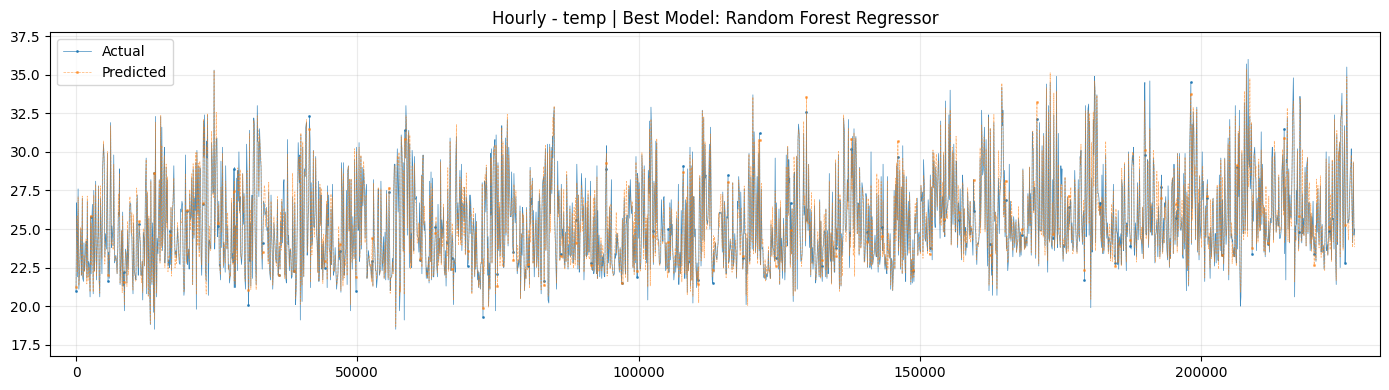

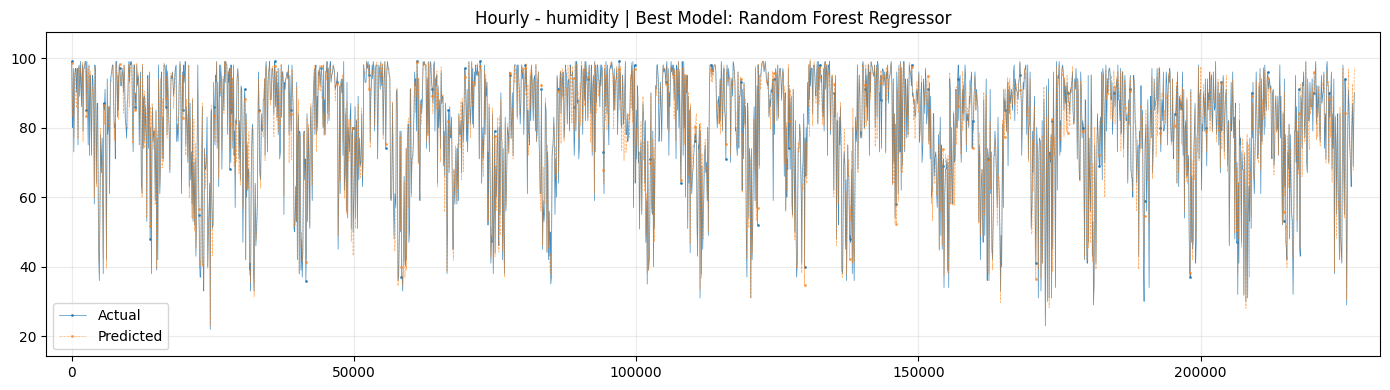

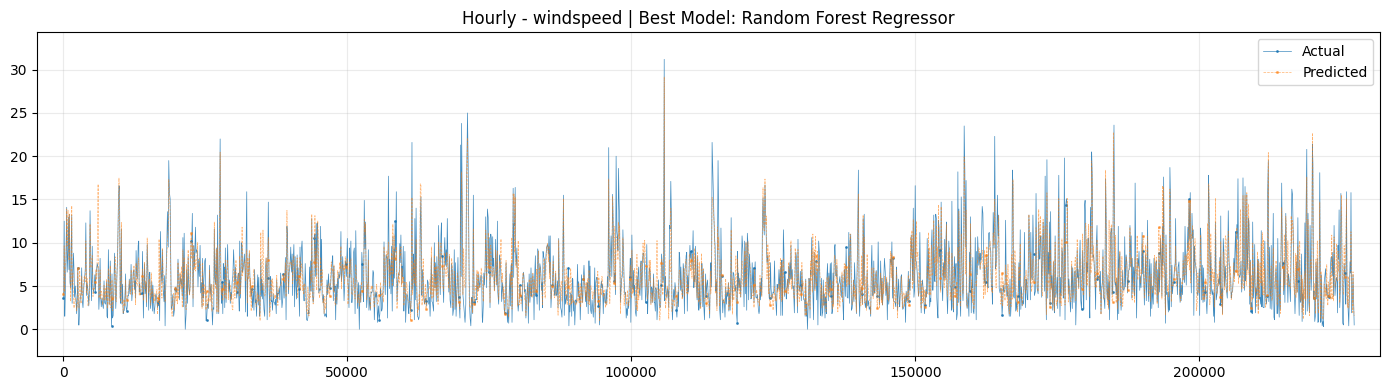

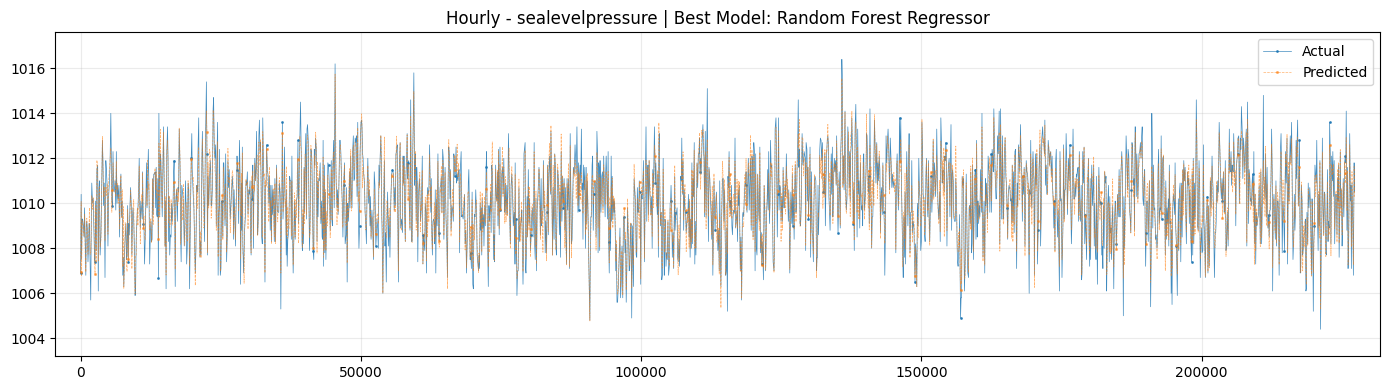


Best Model hourly Regression: Random Forest Regressor

Per-parameter evaluation (hourly):


Parameter        MSE      RMSE       MAE        R2
0              temp   0.472033  0.687047  0.489971  0.948235
1          humidity  19.496878  4.415527  3.026318  0.931767
2         windspeed   4.757790  2.181236  1.578677  0.693394
3  sealevelpressure   0.409059  0.639577  0.484715  0.882988

In [26]:
# Train best models Regression (hourly)
# best_reg_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
for name, model in regression_models.items():
    if name == best_hourly_reg_name:
    # if name == "Random Forest Regressor (Tunned)":
        best_hourly_reg_model = model
        best_hourly_reg_name = name

# Train best model (hourly)
best_hourly_reg_model.fit(X_hourly_train, y_hourly_train_reg)

# Per-parameter evaluation (hourly)
y_hourly_pred = best_hourly_reg_model.predict(X_hourly_test)

y_hourly_pred_df = pd.DataFrame(
    y_hourly_pred,
    columns=hourly_target_reg,
    index=y_hourly_test_reg.index
)

param_results = []

# X axis (timestamp)
if isinstance(y_hourly_test_reg.index, pd.DatetimeIndex):
    x_time = y_hourly_test_reg.index
elif hasattr(X_hourly_test, "columns") and ("timestamp" in X_hourly_test.columns):
    x_time = pd.to_datetime(X_hourly_test["timestamp"])
else:
    x_time = y_hourly_test_reg.index


for param in hourly_target_reg:
    # ====== METRICS ======
    metrics = evaluate_regression(y_hourly_test_reg[param], y_hourly_pred_df[param])
    param_results.append({'Parameter': param, **metrics})

    # ====== DF PLOT ======
    df_plot = pd.DataFrame({
        "timestamp": x_time,
        "Actual": y_hourly_test_reg[param].to_numpy(),
        "Predicted": y_hourly_pred_df[param].to_numpy(),
    }).sort_values("timestamp")

    # drop NaN biar garis gak aneh
    df_plot = df_plot.dropna(subset=["Actual", "Predicted"])

    # ====== DOWNSAMPLE (biar gak terlalu padat) ======
    step = max(1, len(df_plot) // MAX_POINTS)
    df_viz = df_plot.iloc[::step].copy()

    # ====== marker tidak setiap titik ======
    mark_every = max(1, len(df_viz) // MARKER_POINTS)

    # ====== PLOT ======
    fig, ax = plt.subplots(figsize=(14, 4))

    ax.plot(df_viz["timestamp"], df_viz["Actual"],
            linestyle="-", linewidth=LW,
            marker="o", markersize=MS, markevery=mark_every,
            alpha=ALPHA_ACT, label="Actual")

    ax.plot(df_viz["timestamp"], df_viz["Predicted"],
            linestyle="--", linewidth=LW,
            marker="s", markersize=MS, markevery=mark_every,
            alpha=ALPHA_PRED, label="Predicted")

    ax.set_title(f"Hourly - {param} | Best Model: {best_hourly_reg_name}")
    ax.legend()
    ax.grid(True, alpha=0.25)

    # ====== GAP TEPI (simple & efektif) ======
    ax.margins(x=0.02, y=0.10)

    # (opsional) kalau mau y-limit lebih “lega” dan konsisten:
    y_min = min(df_viz["Actual"].min(), df_viz["Predicted"].min())
    y_max = max(df_viz["Actual"].max(), df_viz["Predicted"].max())
    ylo, yhi = _pad_limits(y_min, y_max, pad_pct=0.10)
    ax.set_ylim(ylo, yhi)

    plt.tight_layout()
    plt.show()

print(f"\nBest Model hourly Regression: {best_hourly_reg_name}")
print("\nPer-parameter evaluation (hourly):")
display(pd.DataFrame(param_results))

#### 6.1.2 Daily

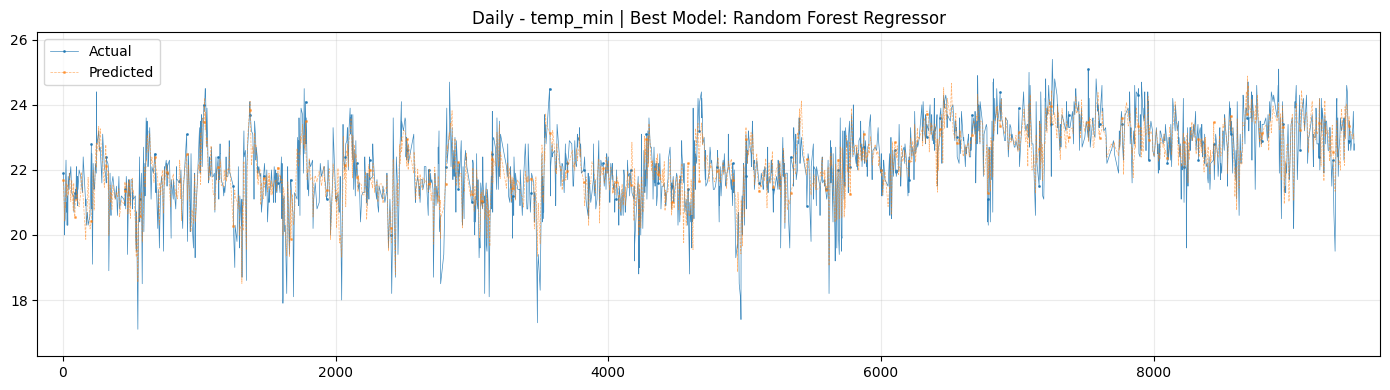

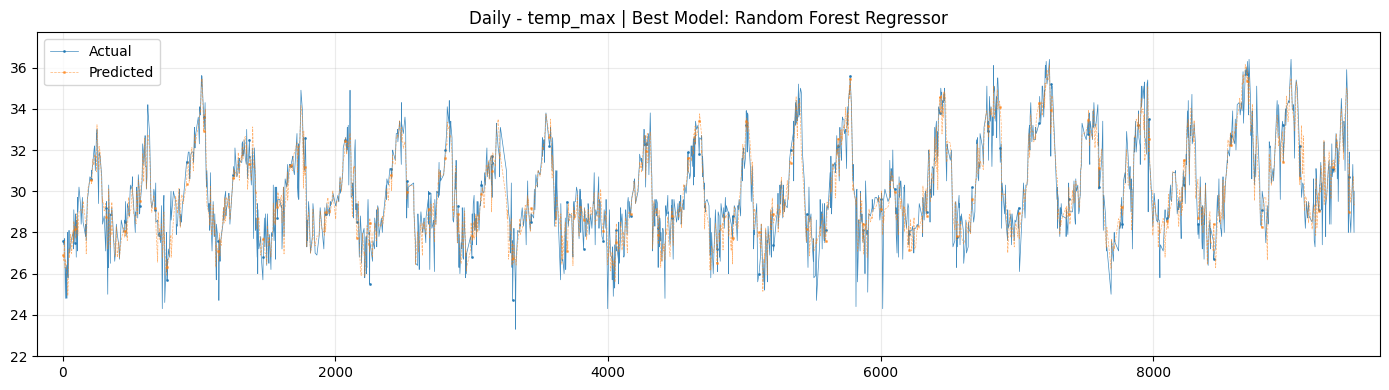

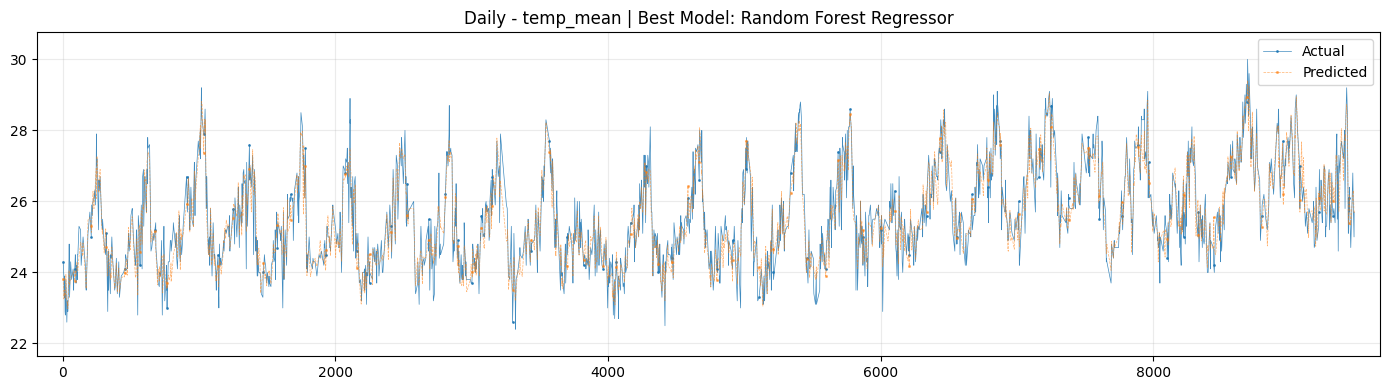

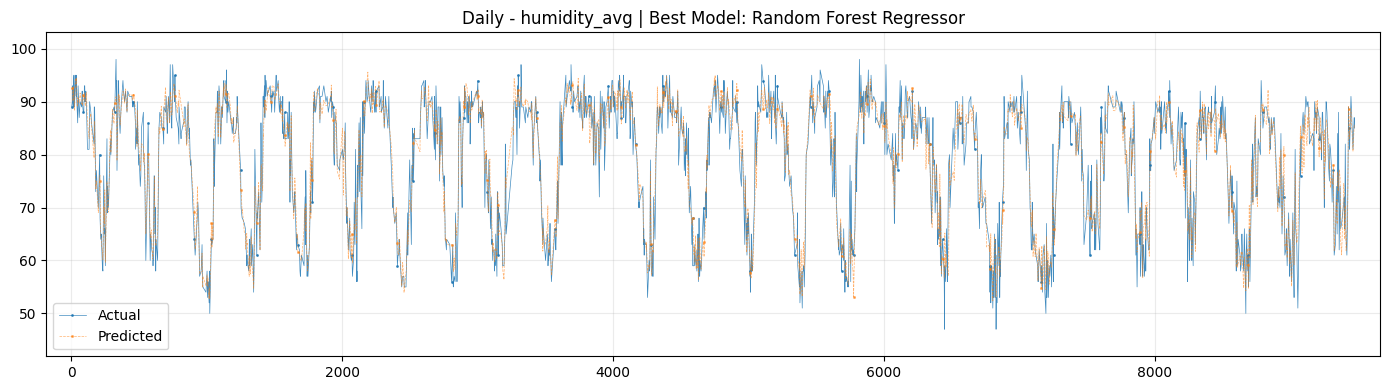

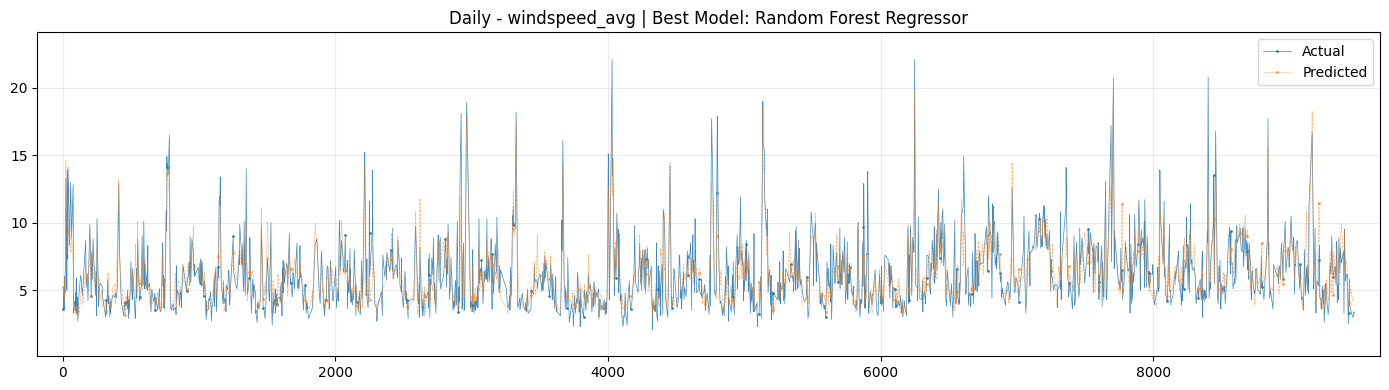

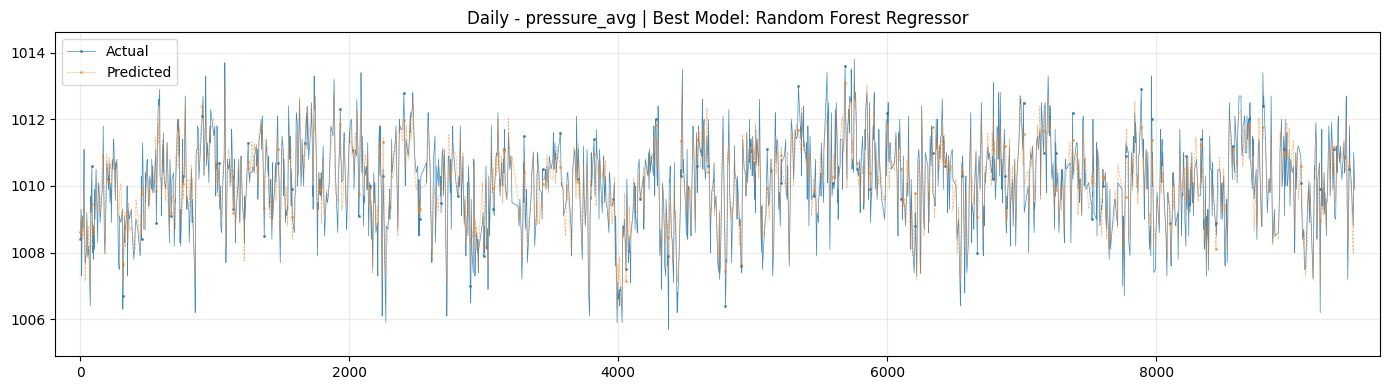


Best Model daily Regression: Random Forest Regressor

Per-parameter evaluation (daily):


Parameter        MSE      RMSE       MAE        R2
0       temp_min   0.468850  0.684726  0.514793  0.670642
1       temp_max   0.814059  0.902252  0.683574  0.851990
2      temp_mean   0.223776  0.473050  0.363777  0.879959
3   humidity_avg  12.720014  3.566513  2.664222  0.912092
4  windspeed_avg   2.165321  1.471503  1.076539  0.677549
5   pressure_avg   0.405696  0.636943  0.504090  0.781293

In [27]:
# Train best models Regression (daily)
# best_daily_reg_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
for name, model in regression_models.items():
    if name == best_daily_reg_name:
    # if name == "Random Forest Regressor (Tunned)":
        best_daily_reg_model = model
        best_daily_reg_name = name

# Train best model (daily)
best_daily_reg_model.fit(X_daily_train, y_daily_train_reg)

# Per-parameter evaluation (daily)
y_daily_pred = best_daily_reg_model.predict(X_daily_test)
y_daily_pred_df = pd.DataFrame(
    y_daily_pred,
    columns=daily_target_reg,
    index=y_daily_test_reg.index)

param_results = []
# X axis (timestamp)
if isinstance(y_daily_test_reg.index, pd.DatetimeIndex):
    x_time = y_daily_test_reg.index
elif hasattr(X_daily_test, "columns") and ("timestamp" in X_daily_test.columns):
    x_time = pd.to_datetime(X_daily_test["timestamp"])
else:
    x_time = y_daily_test_reg.index

for param in daily_target_reg:
    # ====== METRICS ======
    metrics = evaluate_regression(y_daily_test_reg[param], y_daily_pred_df[param])
    param_results.append({'Parameter': param, **metrics})

    # ====== DF PLOT ======
    df_plot = pd.DataFrame({
        "timestamp": x_time,
        "Actual": y_daily_test_reg[param].to_numpy(),
        "Predicted": y_daily_pred_df[param].to_numpy(),
    }).sort_values("timestamp")
    # drop NaN biar garis gak aneh
    df_plot = df_plot.dropna(subset=["Actual", "Predicted"])

    # ====== DOWNSAMPLE (biar gak terlalu padat) ======
    step = max(1, len(df_plot) // MAX_POINTS)
    df_viz = df_plot.iloc[::step].copy()
    # ====== marker tidak setiap titik ======
    mark_every = max(1, len(df_viz) // MARKER_POINTS)

    # ====== PLOT ======
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df_viz["timestamp"], df_viz["Actual"],
            linestyle="-", linewidth=LW,
            marker="o", markersize=MS, markevery=mark_every,
            alpha=ALPHA_ACT, label="Actual")
    ax.plot(df_viz["timestamp"], df_viz["Predicted"],
            linestyle="--", linewidth=LW,
            marker="s", markersize=MS, markevery=mark_every,
            alpha=ALPHA_PRED, label="Predicted")
    ax.set_title(f"Daily - {param} | Best Model: {best_daily_reg_name}")
    ax.legend()
    ax.grid(True, alpha=0.25)
    # ====== GAP TEPI (simple & efektif) ======
    ax.margins(x=0.02, y=0.10)
    # (opsional) kalau mau y-limit lebih “lega” dan konsisten:
    y_min = min(df_viz["Actual"].min(), df_viz["Predicted"].min())
    y_max = max(df_viz["Actual"].max(), df_viz["Predicted"].max())
    ylo, yhi = _pad_limits(y_min, y_max, pad_pct=0.10)
    ax.set_ylim(ylo, yhi)
    plt.tight_layout()
    plt.show()

print(f"\nBest Model daily Regression: {best_daily_reg_name}")
print("\nPer-parameter evaluation (daily):")
display(pd.DataFrame(param_results))

### 6.2 Analisis Individual Klasifikasi

#### 6.2.1 Hourly

In [28]:
# Train best models Classification
# best_hourly_clf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)


# [FIX] Ensure 'hour' column exists in training/test sets if it was accidentally dropped
if 'hour' not in X_hourly_train.columns:
    print("DEBUG: Restoring 'hour' column to X_hourly_train/test...")
    X_hourly_train['hour'] = df_hourly.loc[X_hourly_train.index, 'hour']
    X_hourly_test['hour'] = df_hourly.loc[X_hourly_test.index, 'hour']
    # Ensure column order matches standard
    X_hourly_train = X_hourly_train[['day', 'month', 'year', 'hour']]
    X_hourly_test = X_hourly_test[['day', 'month', 'year', 'hour']]

for name, model in classification_models.items():
    if name == best_hourly_clf_name:
    # if name == "Random Forest Classifier (Tunned)":
        best_hourly_clf_model = model
        best_hourly_clf_name = name

best_hourly_clf_model.fit(X_hourly_train, y_hourly_train_clf)

y_hourly_pred_clf = best_hourly_clf_model.predict(X_hourly_test)
y_hourly_pred_proba_clf = best_hourly_clf_model.predict_proba(X_hourly_test)

hourly_clf_accuracy = accuracy_score(y_hourly_test_clf, y_hourly_pred_clf)
hourly_clf_precision = precision_score(y_hourly_test_clf, y_hourly_pred_clf, average='weighted')
hourly_clf_recall = recall_score(y_hourly_test_clf, y_hourly_pred_clf, average='weighted')
hourly_clf_f1 = f1_score(y_hourly_test_clf, y_hourly_pred_clf, average='weighted')


In [29]:
print(f"=== HOURLY ===")
print(f"\nBest Model: {best_hourly_clf_name}")
print(f"\nAccuracy: {hourly_clf_accuracy:.4f}")
print(f"Precision (weighted): {hourly_clf_precision:.4f}")
print(f"Recall (weighted): {hourly_clf_recall:.4f}")
print(f"F1-Score (weighted): {hourly_clf_f1:.4f}")

print("\nReport:")
print(classification_report(y_hourly_test_clf, y_hourly_pred_clf, target_names=le_conditions.classes_))


=== HOURLY ===

Best Model: Random Forest Classifier

Accuracy: 0.5435
Precision (weighted): 0.5393
Recall (weighted): 0.5435
F1-Score (weighted): 0.5404

Report:
                  precision    recall  f1-score   support

           Clear       0.52      0.45      0.48      4648
        Overcast       0.60      0.64      0.62     16452
Partially cloudy       0.51      0.51      0.51     10923
            Rain       0.53      0.53      0.53     10697
  Rain, Overcast       0.39      0.29      0.33      2751

        accuracy                           0.54     45471
       macro avg       0.51      0.48      0.49     45471
    weighted avg       0.54      0.54      0.54     45471



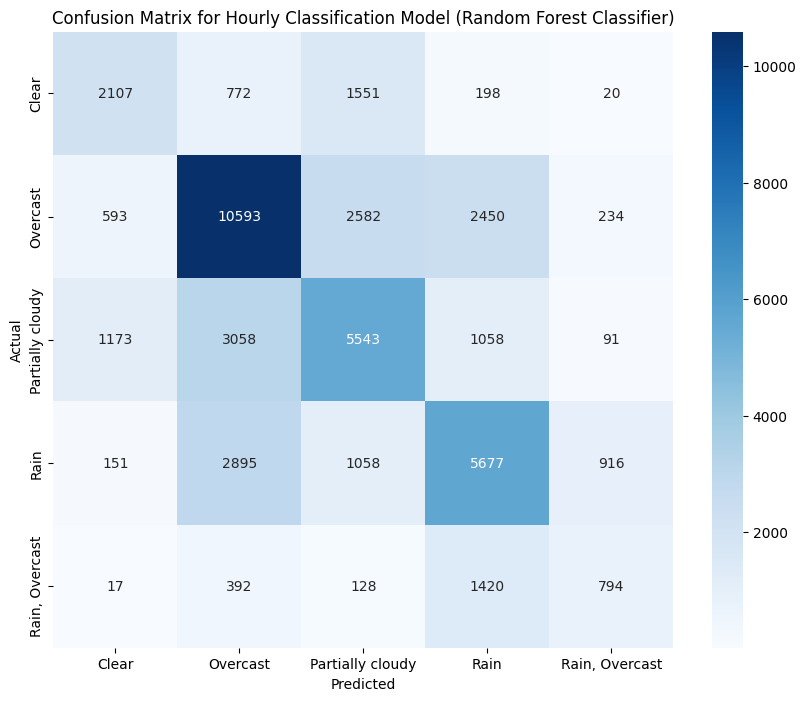

In [30]:
cm = confusion_matrix(y_hourly_test_clf, y_hourly_pred_clf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_conditions.classes_, yticklabels=le_conditions.classes_)
plt.title(f'Confusion Matrix for Hourly Classification Model ({best_hourly_clf_name})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 6.2.2 Daily

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train best models Classification
# best_daily_clf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
for name, model in classification_models.items():
    if name == best_daily_clf_name:
    # if name == "Random Forest Classifier (Tunned)":
        best_daily_clf_model = model
        best_daily_clf_name = name

best_daily_clf_model.fit(X_daily_train, y_daily_train_clf)

y_daily_pred_clf = best_daily_clf_model.predict(X_daily_test)
y_daily_pred_proba_clf = best_daily_clf_model.predict_proba(X_daily_test)

daily_clf_accuracy = accuracy_score(y_daily_test_clf, y_daily_pred_clf)
daily_clf_precision = precision_score(y_daily_test_clf, y_daily_pred_clf, average='weighted')
daily_clf_recall = recall_score(y_daily_test_clf, y_daily_pred_clf, average='weighted')
daily_clf_f1 = f1_score(y_daily_test_clf, y_daily_pred_clf, average='weighted')


In [32]:
print(f"=== DAILY ===")
print(f"\nBest Model: {best_daily_clf_name}")
print(f"\nAccuracy: {daily_clf_accuracy:.4f}")
print(f"Precision (weighted): {daily_clf_precision:.4f}")
print(f"Recall (weighted): {daily_clf_recall:.4f}")
print(f"F1-Score (weighted): {daily_clf_f1:.4f}")

print("\nReport:")
print(classification_report(y_daily_test_clf, y_daily_pred_clf, target_names=le_conditions_daily.classes_))


=== DAILY ===

Best Model: Random Forest Classifier

Accuracy: 0.5441
Precision (weighted): 0.5375
Recall (weighted): 0.5441
F1-Score (weighted): 0.5386

Report:
                  precision    recall  f1-score   support

           Clear       0.47      0.30      0.37       178
        Overcast       0.60      0.65      0.62       871
Partially cloudy       0.48      0.51      0.50       487
            Rain       0.51      0.48      0.50       345
  Rain, Overcast       0.00      0.00      0.00        14

        accuracy                           0.54      1895
       macro avg       0.41      0.39      0.40      1895
    weighted avg       0.54      0.54      0.54      1895



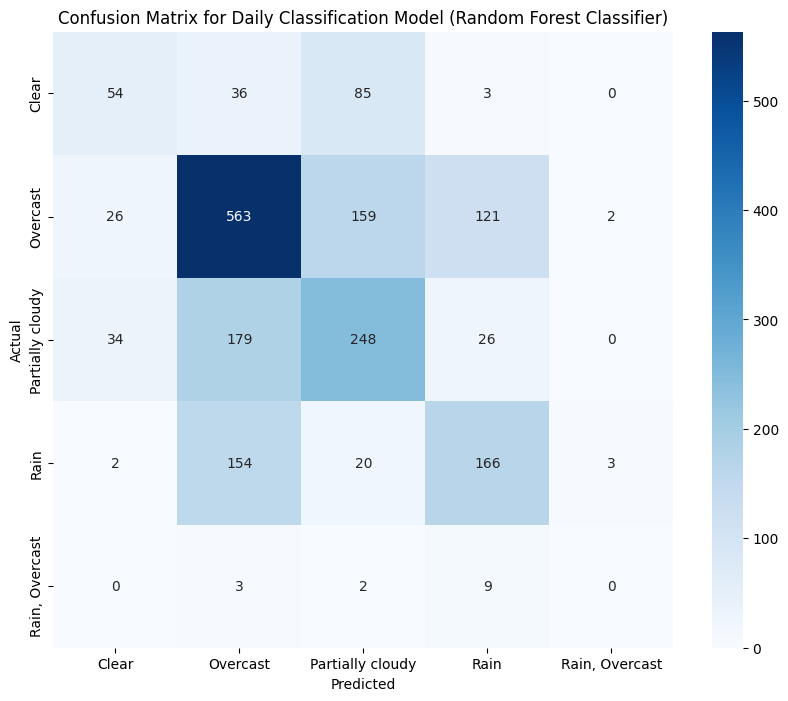

In [33]:
cm = confusion_matrix(y_daily_test_clf, y_daily_pred_clf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_conditions.classes_, yticklabels=le_conditions.classes_)
plt.title(f'Confusion Matrix for Daily Classification Model ({best_daily_clf_name})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 6.2 Visualisasi Januari 2020 (Gap 2 Hari)

In [34]:
year = 2020
month = 1
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# --- FIX START: Sanitize Hourly Model ---
# The best_hourly_clf_model might have been overwritten by daily model training (3 features).
print("Sanitizing best_hourly_clf_model for Hourly prediction (4 features)...")
hourly_feature_cols = ['day', 'month', 'year', 'hour']
best_hourly_clf_model.fit(X_hourly_train, y_hourly_train_clf)
print("best_hourly_clf_model successfully refitted.")
# --- FIX END ---


Sanitizing best_hourly_clf_model for Hourly prediction (4 features)...
best_hourly_clf_model successfully refitted.


--- Regression Performance Evaluation (Daily Data) ---


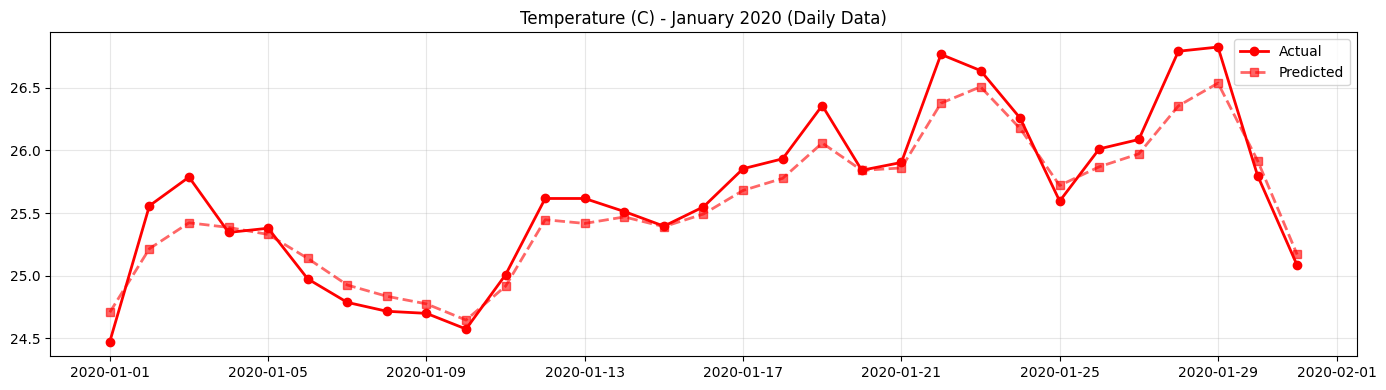


Temperature (C) Metrics:
  R-squared: 0.9125
  MAE: 0.1532
  MSE: 0.0364
  RMSE: 0.1907


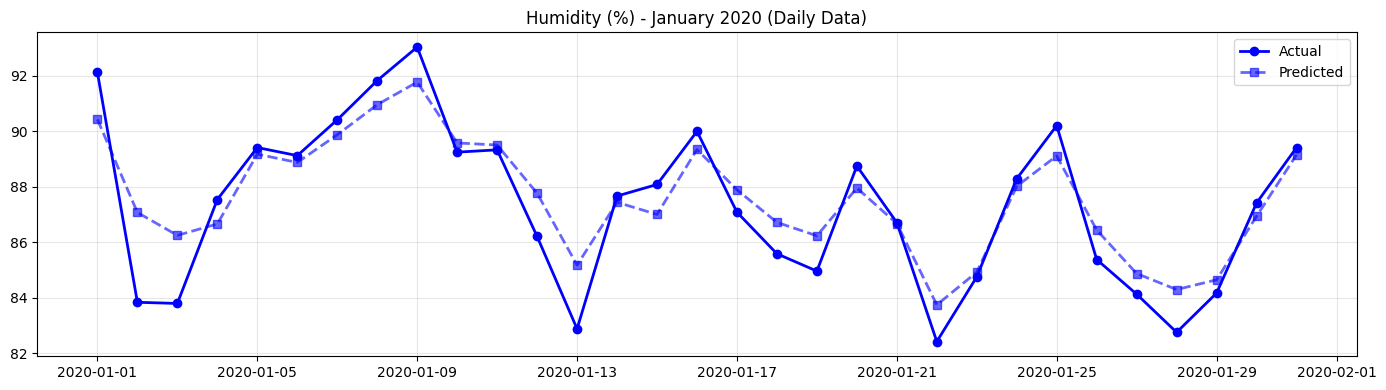


Humidity (%) Metrics:
  R-squared: 0.8263
  MAE: 0.9429
  MSE: 1.4284
  RMSE: 1.1952


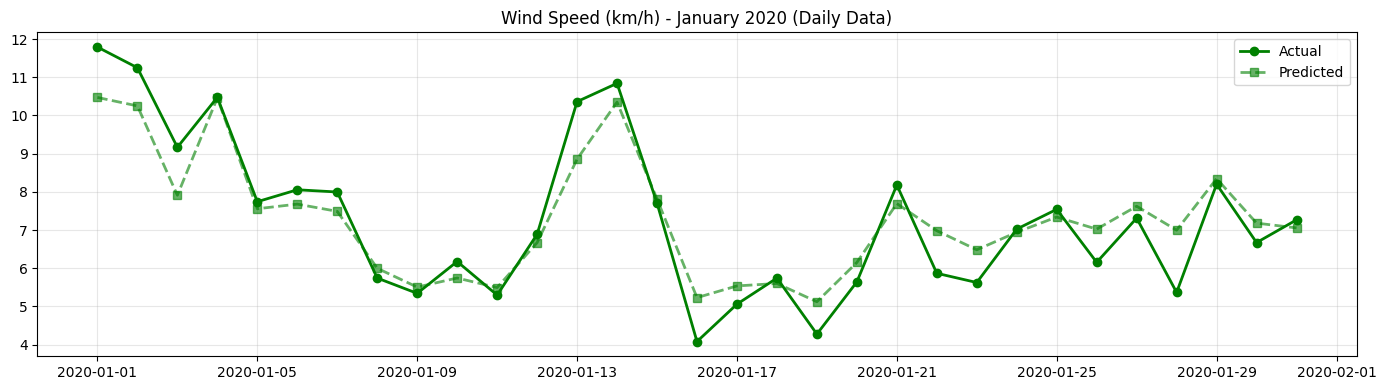


Wind Speed (km/h) Metrics:
  R-squared: 0.8709
  MAE: 0.5668
  MSE: 0.5251
  RMSE: 0.7247


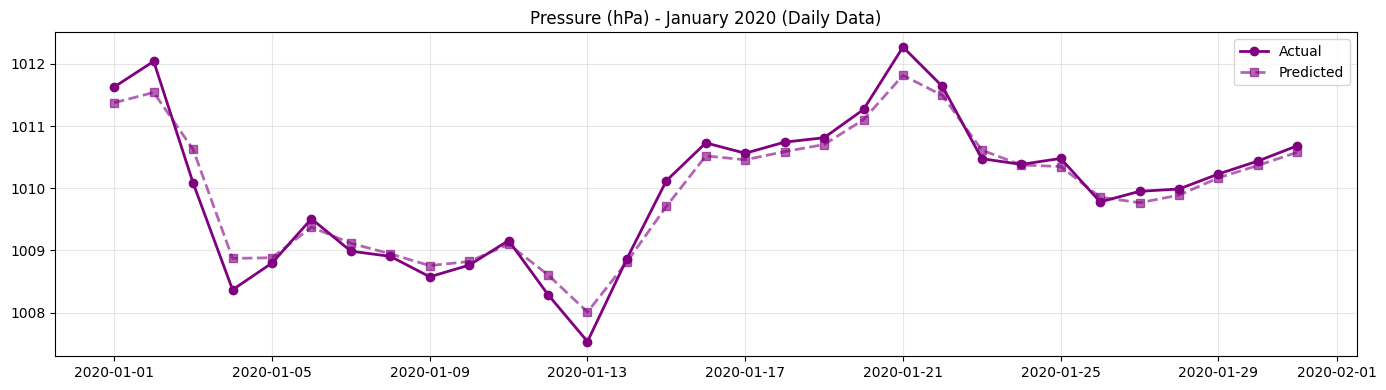


Pressure (hPa) Metrics:
  R-squared: 0.9536
  MAE: 0.1923
  MSE: 0.0612
  RMSE: 0.2473


In [35]:

month_mask = (df_hourly['year'] == year) & (df_hourly['month'] == month)
df_month = df_hourly[month_mask].copy()

if len(df_month) > 0:
    X_month = df_month[hourly_feature_cols]
    y_month_pred = best_hourly_reg_model.fit(X_hourly_train, y_hourly_train_reg).predict(X_month)
    df_month['temp_pred'] = y_month_pred[:, 0]
    df_month['humidity_pred'] = y_month_pred[:, 1]
    df_month['windspeed_pred'] = y_month_pred[:, 2]
    df_month['pressure_pred'] = y_month_pred[:, 3]

    df_month_daily = df_month.set_index('timestamp').resample('D').mean(numeric_only=True).reset_index()

    params = [('temp', 'temp_pred', 'Temperature (C)', 'red'),
              ('humidity', 'humidity_pred', 'Humidity (%)', 'blue'),
              ('windspeed', 'windspeed_pred', 'Wind Speed (km/h)', 'green'),
              ('sealevelpressure', 'pressure_pred', 'Pressure (hPa)', 'purple')]

    # os.makedirs('outputs', exist_ok=True)

    print("--- Regression Performance Evaluation (Daily Data) ---")
    for actual, pred, title, color in params:
        fig, ax = plt.subplots(figsize=(14, 4)) # Create a new figure for each parameter
        ax.plot(df_month_daily['timestamp'], df_month_daily[actual], '-o', color=color, label='Actual', linewidth=2)
        ax.plot(df_month_daily['timestamp'], df_month_daily[pred], '--s', color=color, alpha=0.6, label='Predicted', linewidth=2)
        ax.set_title(f'{title} - {month_map[month]} {year} (Daily Data)')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        # plt.savefig(f'outputs/jan_2022_predictions_{actual}_v4.png', dpi=150)
        plt.show()

        # Performance Evaluation
        mae = mean_absolute_error(df_month_daily[actual], df_month_daily[pred])
        mse = mean_squared_error(df_month_daily[actual], df_month_daily[pred])
        rmse = np.sqrt(mse)
        r2 = r2_score(df_month_daily[actual], df_month_daily[pred])
        print(f"\n{title} Metrics:")
        print(f"  R-squared: {r2:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
else:
    print(f'No data for {month_map[month]} {year}')

### 6.3 Confusion Matrix

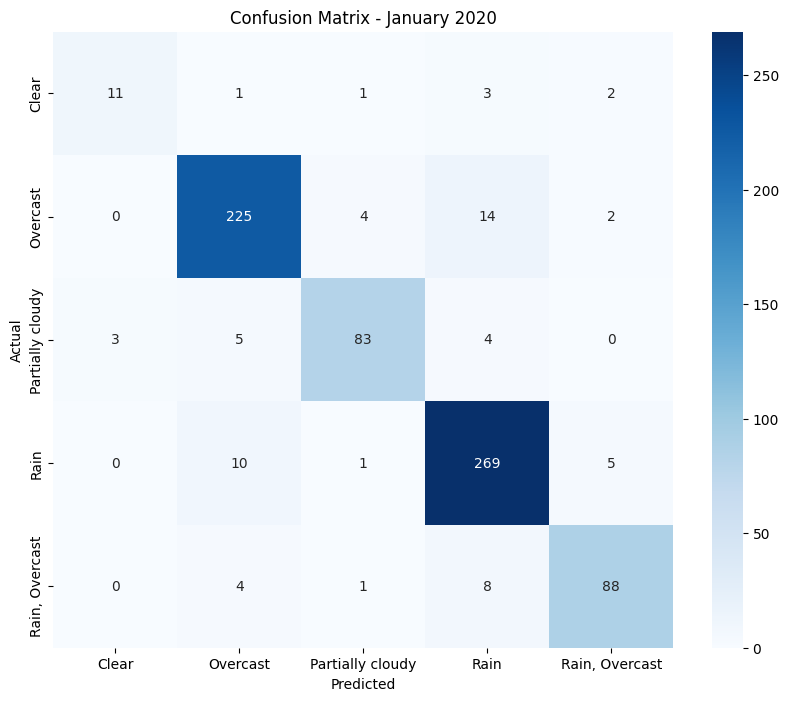

                  precision    recall  f1-score   support

           Clear       0.79      0.61      0.69        18
        Overcast       0.92      0.92      0.92       245
Partially cloudy       0.92      0.87      0.90        95
            Rain       0.90      0.94      0.92       285
  Rain, Overcast       0.91      0.87      0.89       101

        accuracy                           0.91       744
       macro avg       0.89      0.84      0.86       744
    weighted avg       0.91      0.91      0.91       744



In [36]:
if len(df_month) > 0:
    y_month_clf_pred = best_hourly_clf_model.predict(X_month)
    cm = confusion_matrix(df_month['conditions_encoded'], y_month_clf_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_conditions.classes_, yticklabels=le_conditions.classes_)
    plt.title(f'Confusion Matrix - {month_map[month]} {year}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(classification_report(df_month['conditions_encoded'], y_month_clf_pred, target_names=[str(c) for c in le_conditions.classes_]))

## 6.5 Retraining with 100% Data

In [37]:
# [v4.0] FINAL RETRAINING WITH 100% DATA
# Ensure feature columns are correct
hourly_feature_cols = ['day', 'month', 'year', 'hour']
daily_feature_cols = ['day', 'month', 'year']

# Hourly Data
X_hourly_full = df_hourly[hourly_feature_cols]
y_hourly_reg_full = df_hourly[hourly_target_reg]
y_hourly_clf_full = df_hourly[hourly_target_clf]

print('Training final HOURLY models (Random Forest)...')
# Menggunakan Random Forest untuk menangkap pola musiman non-linear
hourly_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=14, min_samples_split=20, min_samples_leaf=5, max_features=0.7, bootstrap=True)
hourly_regressor.fit(X_hourly_full, y_hourly_reg_full)

hourly_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=14, min_samples_split=20, min_samples_leaf=5,
             max_features=0.7, bootstrap=True, class_weight="balanced_subsample")
hourly_classifier.fit(X_hourly_full, y_hourly_clf_full)

# Daily Data
X_daily_full = df_daily[daily_feature_cols]
y_daily_reg_full = df_daily[daily_target_reg]
y_daily_clf_full = df_daily[daily_target_clf]

print('Training final DAILY models (Random Forest)...')
daily_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=14, min_samples_split=20, min_samples_leaf=5, max_features=0.7, bootstrap=True)
daily_regressor.fit(X_daily_full, y_daily_reg_full)

daily_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=14, min_samples_split=20, min_samples_leaf=5,
             max_features=0.7, bootstrap=True, class_weight="balanced_subsample")
daily_classifier.fit(X_daily_full, y_daily_clf_full)

print('All 4 final models trained (Random Forest)!')

Training final HOURLY models (Random Forest)...
Training final DAILY models (Random Forest)...
All 4 final models trained (Random Forest)!


## 7. Save Models (7 Files)

In [38]:
import os
import sys
import joblib
import sklearn
from datetime import datetime, timezone

os.makedirs("models", exist_ok=True)

conditions_to_rain = {0:0, 1:0, 2:0, 3:0, 51:0.2, 53:0.7, 55:1.1, 61:1.7, 63:4.0, 65:10.3}

# ===== helpers =====
def unwrap_estimator(est):
    """Jika est adalah GridSearchCV/RandomizedSearchCV, ambil best_estimator_ saja."""
    return est.best_estimator_ if hasattr(est, "best_estimator_") else est

def dump_xz(obj, path, level=3):
    """Simpan joblib dengan kompresi (file kecil). level 3 biasanya sweet spot."""
    joblib.dump(obj, path, compress=("xz", level), protocol=5)

# ===== pastikan yang disimpan adalah estimator final (tidak bengkak) =====
hourly_reg = unwrap_estimator(hourly_regressor)
hourly_clf = unwrap_estimator(hourly_classifier)
daily_reg  = unwrap_estimator(daily_regressor)
daily_clf  = unwrap_estimator(daily_classifier)

# ===== schema / metadata untuk backend =====
meta = {
    "version": "4.0",
    "trained_date_utc": datetime.now(timezone.utc).isoformat(),
    "python_version": sys.version,
    "sklearn_version": sklearn.__version__,
}

# Pastikan pakai list fitur yang benar (biar tidak mismatch)
# Kalau kamu sudah punya hourly_feature_cols & daily_feature_cols, gunakan itu.
# Jika belum, fallback ke list default.
hourly_cols = hourly_feature_cols if "hourly_feature_cols" in globals() else ["day", "month", "year", "hour"]
daily_cols  = daily_feature_cols  if "daily_feature_cols"  in globals() else ["day", "month", "year"]

# ===== 1. COMBINED MODEL =====
combined_package = {
    "hourly": {
        "regressor": hourly_reg,
        "classifier": hourly_clf,
        "feature_columns": hourly_cols,
        "target_regression": hourly_target_reg,
        "target_classification": "conditions",   # label asli sebelum encoded
        "label_encoder": le_conditions,
    },
    "daily": {
        "regressor": daily_reg,
        "classifier": daily_clf,
        "feature_columns": daily_cols,
        "target_regression": daily_target_reg,
        "target_classification": "conditions_daily",  # sesuaikan dengan target harian kamu
        "label_encoder": le_conditions_daily,
    },

    # mapping tambahan untuk post-processing
    "conditions_to_rain": conditions_to_rain,

    # metadata
    "meta": meta,

    # alias (opsional) untuk kompatibilitas dengan kode lama
    "label_encoder_hourly": le_conditions,
    "label_encoder_daily": le_conditions_daily,
    "label_encoder_conditions": le_conditions,
}

dump_xz(combined_package, "models/v4_weather_model_combined.joblib")
print("1. Combined model saved")

# ===== 2. HOURLY MODEL =====
hourly_package = {
    "regressor": hourly_reg,
    "classifier": hourly_clf,
    "feature_columns": hourly_cols,
    "target_regression": hourly_target_reg,
    "target_classification": "conditions",
    "label_encoder": le_conditions,
    "conditions_to_rain": conditions_to_rain,
    "meta": meta,
}
dump_xz(hourly_package, "models/v4_weather_model_hourly.joblib")
print("2. Hourly model saved")

# ===== 3. DAILY MODEL =====
daily_package = {
    "regressor": daily_reg,
    "classifier": daily_clf,
    "feature_columns": daily_cols,
    "target_regression": daily_target_reg,
    "target_classification": "conditions_daily",
    "label_encoder": le_conditions_daily,
    "conditions_to_rain": conditions_to_rain,
    "meta": meta,
}
dump_xz(daily_package, "models/v4_weather_model_daily.joblib")
print("3. Daily model saved")

# ===== 4-7. SEPARATE FILES =====
dump_xz({"model": hourly_reg, "feature_columns": hourly_cols, "target": hourly_target_reg, "meta": meta},
        "models/v4_weather_model_hourly_regressor.joblib")
print("4. Hourly regressor saved")

dump_xz({"model": hourly_clf, "feature_columns": hourly_cols, "label_encoder": le_conditions, "meta": meta},
        "models/v4_weather_model_hourly_classifier.joblib")
print("5. Hourly classifier saved")

dump_xz({"model": daily_reg, "feature_columns": daily_cols, "target": daily_target_reg, "meta": meta},
        "models/v4_weather_model_daily_regressor.joblib")
print("6. Daily regressor saved")

dump_xz({"model": daily_clf, "feature_columns": daily_cols, "label_encoder": le_conditions_daily, "meta": meta},
        "models/v4_weather_model_daily_classifier.joblib")
print("7. Daily classifier saved")

print("\n7 model files saved to models/ folder!")


1. Combined model saved
2. Hourly model saved
3. Daily model saved
4. Hourly regressor saved
5. Hourly classifier saved
6. Daily regressor saved
7. Daily classifier saved

7 model files saved to models/ folder!


## 8. Multi-Step Forecasting

In [39]:
def predict_future_weather_v4(model_reg, model_clf, start_date, n_hours=24):
    future_dates = [start_date + pd.Timedelta(hours=i) for i in range(n_hours)]
    
    # Buat DataFrame Input (HANYA WAKTU)
    features = pd.DataFrame({
        'day': [d.day for d in future_dates],
        'month': [d.month for d in future_dates],
        'year': [d.year for d in future_dates],
        'hour': [d.hour for d in future_dates]
    })
    
    # Predict
    reg_pred = model_reg.predict(features)
    clf_pred = model_clf.predict(features)
    
    # Format Output
    results = []
    for i, date in enumerate(future_dates):
        results.append({
            'timestamp': date,
            'temp': reg_pred[i][0],
            'humidity': reg_pred[i][1],
            'windspeed': reg_pred[i][2],
            'sealevelpressure': reg_pred[i][3],
            'conditions': clf_pred[i]
        })
        
    return pd.DataFrame(results)

## 9. Visualize Forecast

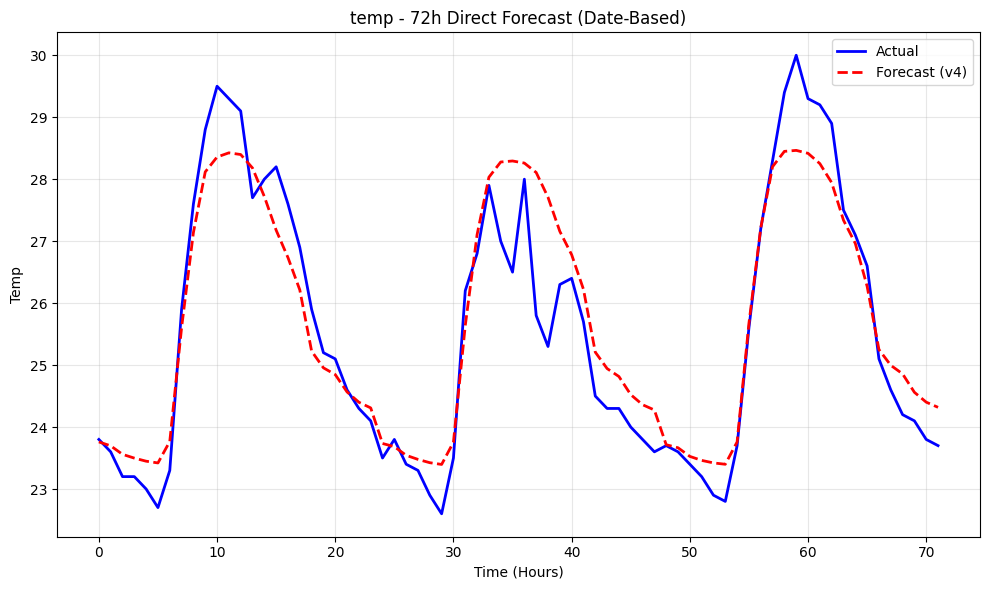

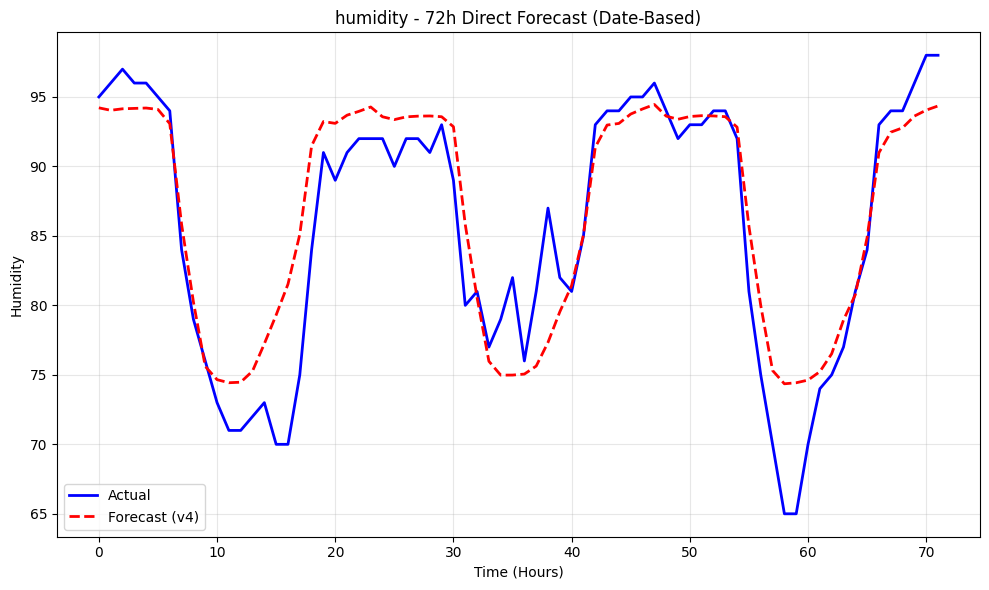

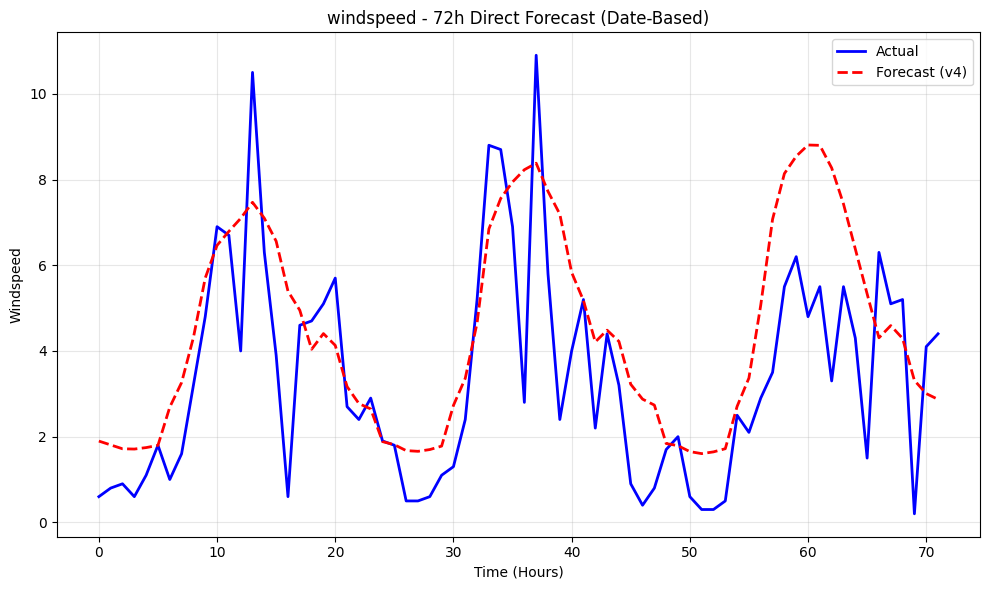

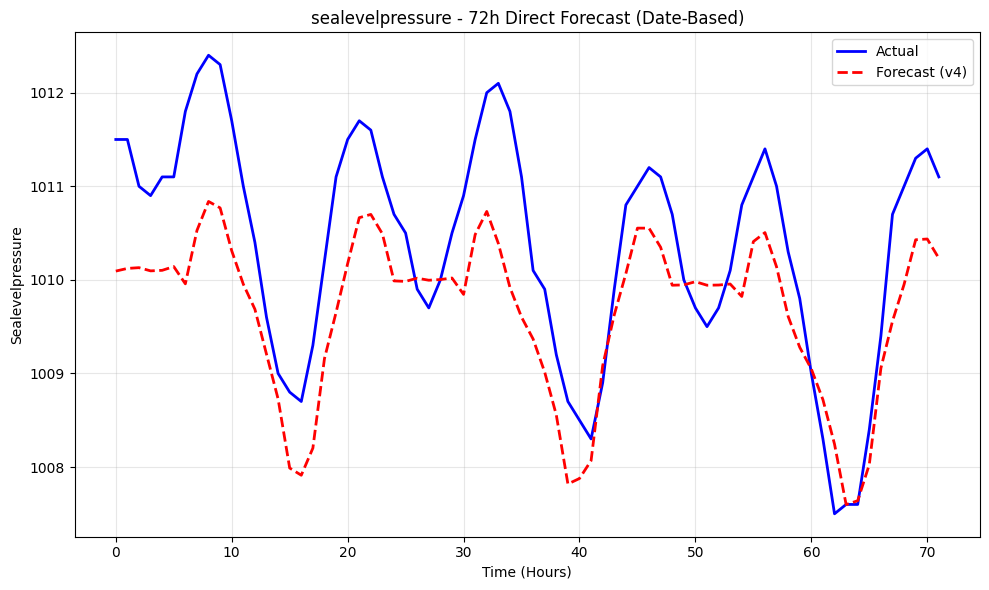

In [40]:
# [v4.0] Visualization using Direct Forecast
# Load trained models from current session (or v4 file)
loaded_reg_model = hourly_regressor
loaded_clf_model = hourly_classifier

# Generate forecast for last 72 hours of test set
start_date = df_hourly['timestamp'].iloc[-72]
forecast = predict_future_weather_v4(loaded_reg_model, loaded_clf_model, start_date, n_hours=72)

actual_72h = df_hourly.tail(72).reset_index(drop=True)

params = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
actual_cols = ['temp', 'humidity', 'windspeed', 'sealevelpressure']

for param, actual_col in zip(params, actual_cols):
    fig, ax = plt.subplots(figsize=(10, 6)) # Create a new figure and axes for each parameter
    ax.plot(actual_72h.index, actual_72h[actual_col].values, 'b-', label='Actual', linewidth=2)
    ax.plot(forecast.index, forecast[param].values, 'r--', label='Forecast (v4)', linewidth=2)
    ax.set_title(f'{param} - 72h Direct Forecast (Date-Based)')
    ax.set_xlabel('Time (Hours)') # X-axis label
    ax.set_ylabel(param.capitalize()) # Y-axis label, capitalized for better readability
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'outputs/direct_forecast_72h_v4_{param}.png', dpi=150) # Save each figure separately
    plt.show()

## 10. Incremental Learning Impact

 10%: R2 = 0.6793
 20%: R2 = 0.7322
 30%: R2 = 0.7636
 40%: R2 = 0.7864
 50%: R2 = 0.8069
 60%: R2 = 0.8220
 70%: R2 = 0.8333
 80%: R2 = 0.8447
 90%: R2 = 0.8540
100%: R2 = 0.8622


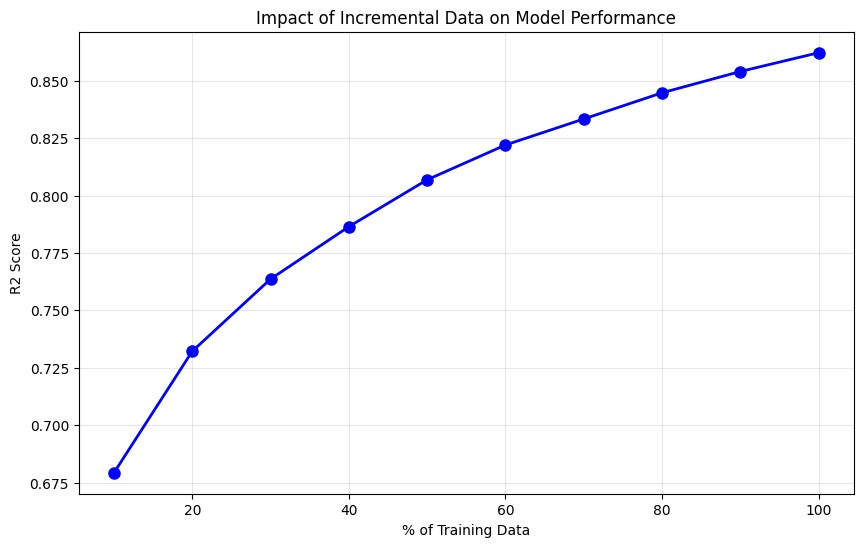

In [41]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
r2_scores = []

for frac in fractions:
    n = int(len(X_hourly_train) * frac)
    temp_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    temp_model.fit(X_hourly_train.iloc[:n], y_hourly_train_reg.iloc[:n])
    r2 = r2_score(y_hourly_test_reg, temp_model.predict(X_hourly_test))
    r2_scores.append(r2)
    print(f'{int(frac*100):3d}%: R2 = {r2:.4f}')

plt.figure(figsize=(10, 6))
plt.plot([f*100 for f in fractions], r2_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('% of Training Data')
plt.ylabel('R2 Score')
plt.title('Impact of Incremental Data on Model Performance')
plt.grid(True, alpha=0.3)
plt.savefig('outputs/incremental_learning.png', dpi=150)
plt.show()